## Machine Learning 프로젝트 수행을 위한 코드 구조화

- ML project(분류, 회귀 Task)를 위해서 사용하는 템플릿 코드를 만듭니다.


1. **필요한 라이브러리와 데이터를 불러옵니다.**

2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.

3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.

4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.

5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.

6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.

7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

In [ ]:
!pip install optuna 

In [10]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
# RandomForestRegressor : bagging model 사용, 트리가 depth-wise -> 부스팅의 오버피팅을 상쇄시키는 효과 존재
# LGBMRegressor : 성능 좋고 빠르기 때문에 주로 사용

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, variance_inflation_factor(VIF) : 다중공선성 제거에 유용한 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [11]:
# flag setting : 데이터가 너무 큰 경우 사용하는 테크닉
data_reducing = False ## memory reducing technique
feature_reducing = True ## feature extraction (curse of dimensionality)

In [12]:
# 데이터를 불러옵니다.
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/fastcamp/datas/drive/"

train = pd.read_csv(base_path + "train.csv")
test = pd.read_csv(base_path + "test.csv")

Mounted at /content/drive


In [13]:
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (4209, 378)
Test shape :  (4209, 377)


## 2. EDA : 목적 -> 데이터에 대한 이해

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

1) Target Variable : "y" is the variable we need to predict. So let us do some analysis on this variable first.

In [14]:
train.head() #.column.value_counts()
# sns.scatter() -> 250 넘는 점 하나 존재
# sns.countplot() -> columns가 너무 많아서 별 의미가 없는듯?
# sns.histplot() -> 250을 제거하기 위해 upper limit 지정하고 그려주자.

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [15]:
test.head() #.column.value_counts()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


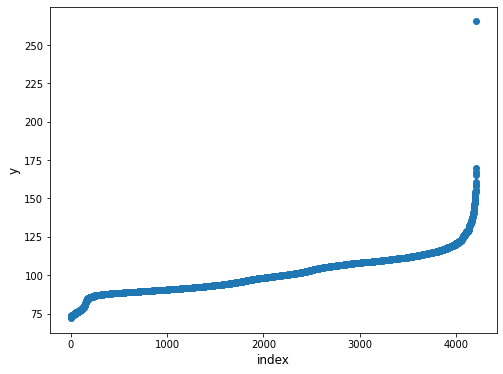

In [16]:
plt.figure(figsize=(8,6))
# train.shape[0] -> row 갯수
# train.y.values -> y 값들 
plt.scatter(range(train.shape[0]), np.sort(train.y.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

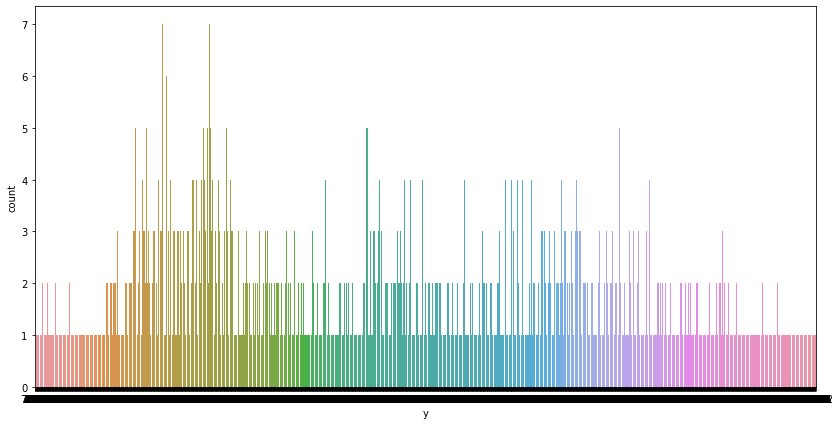

In [17]:
plt.figure(figsize = (14, 7))
sns.countplot(data = train, x = train.y)
plt.show()

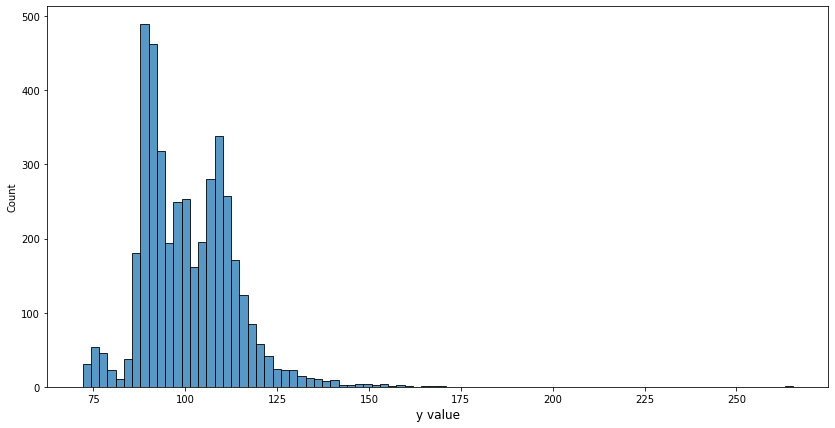

In [18]:
plt.figure(figsize = (14, 7))
sns.histplot(data = train, x = train.y)
plt.xlabel('y value', fontsize=12)
plt.show()

2) Now let us have a look at the data type of all the variables present in the dataset.
- 결과 : 

int64 -> 369

categorical columns -> 8

float64 -> 1 (target variable)

In [19]:
dtype_df = train.dtypes.reset_index() # train.dtypes.reset_index() -> 판다스 시리즈에서 데이터프레임이 만들어진다..!
dtype_df.columns = ["Count", "Column Type"] # 컬럼명 바꾸기
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,369
1,float64,1
2,object,8


In [20]:
dtype_df.loc[dtype_df["Column Type"] == "object",:] # -> X2 to X9 are the categorical columns.

,Count,Column Type
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


3) Missing values: Let us now check for the missing values.
- 결과 : no missing values in the dataset

In [21]:
#train.isnull().sum(axis=0).reset_index()
missing_df = train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_count']>0
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


4) Integer Columns Analysis

In [22]:
unique_values_dict = {}
for col in train.columns:
    if col not in ["ID", "y", "X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        unique_value = str(np.sort(train[col].unique()).tolist())
        tlist = unique_values_dict.get(unique_value, []) # dic.get(key, value) -> key에 대해서 빈 리스트를 만들어준다.
        tlist.append(col) # 같은 key값인 경우 리스트가 append된다.  
        unique_values_dict[unique_value] = tlist[:] # 리스트가 완성되면 dic에 저장한다. 
        #print(unique_values_dict)
for unique_val, columns in unique_values_dict.items():
    print("Columns containing the unique values : ",unique_val)
    print(columns)
    print("--------------------------------------------------")

Columns containing the unique values :  [0, 1]
['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145'

5) Categorical Columns Analysis 

In [ ]:
col = ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]
for var_name in col : 
  col_order = np.sort(train[var_name].unique()).tolist()
  plt.figure(figsize=(12,6))
  sns.boxplot(x=var_name, y='y', data=train, order=col_order)
  plt.xlabel(var_name, fontsize=12)
  plt.ylabel('y', fontsize=12)
  plt.title("Distribution of y variable with " + var_name, fontsize=15)
  plt.show()

5) Binary Variables : [0, 1]

In [ ]:
zero_count_list = []
one_count_list = []
cols_list = unique_values_dict['[0, 1]']
for col in cols_list:
    zero_count_list.append((train[col]==0).sum())
    one_count_list.append((train[col]==1).sum())

N = len(cols_list)
ind = np.arange(N)
width = 0.35

plt.figure(figsize=(6,100))
p1 = plt.barh(ind, zero_count_list, width, color='red')
p2 = plt.barh(ind, one_count_list, width, left=zero_count_list, color="blue")
plt.yticks(ind, cols_list)
plt.legend((p1[0], p2[0]), ('Zero count', 'One Count'))
plt.show()

### 3. 전처리 : 목적 -> 프로젝트의 결과(목표)를 위한 데이터 가공. 따라서 목표를 정확히 인지해야 제대로된 전처리가 가능하다. 

- 해당 대회에서는 차원의 저주를 해결하는 것이 목표, 즉 차원을 축소하는 것이 우리의 목적이다. 
- 따라서 열의 정보가치가 낮은 경우 삭제하는 것이 이번 전처리의 목표가 될 것이다. 
- 방법론 1) 값이 하나인 열을 삭제한다. 
- 방법론 2) 분산이 낮은 열을 삭제한다. 
- 방법론 3) 상관계수가 높은 열들 삭제한다.

1) 결측치가 있는 column -> 없어서 생략

2) Feature Selection 
- 정의: 특정 feature에 종속성이 강하여 불필요한 feature는 아예 제거하고, 데이터의 특징을 잘 나타내는 주요 feature만 선택하는 것이다.

- 방법
    
  1) variance check : 각 feature(col)의 분산이 "없는" 경우와 "낮은" 경우 제거
    -> why? 모든 row가 갖고 있는 값은 차이를 만들지 않을 것, 즉 중요도가 떨어진다. 

  2) corr check : feature간 공분산이 높아 선형관계에 가까운 경우 제거 
 

2.1) 값이 하나 뿐인 column을 제거 -> 분산 = 0

In [26]:
# drop features with 1 unique value
def basic_details(df):
    b = pd.DataFrame()
    b['Missing value'] = df.isnull().sum()
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b

check_one_unique = basic_details(train)
one_value_cols = list(check_one_unique.loc[check_one_unique["N unique value"] == 1, :].index)
one_value_cols

train.drop(one_value_cols, axis=1, inplace=True)
train.drop(columns = "ID", inplace=True)

2.2) 중복정보가 있는 column 제거 -> 분산 0에 가까움

In [38]:
## drop features with low variabiliry
variance_treshold = 0.9
low_var_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > variance_treshold]
train=train.drop(low_var_cols, axis=1) 

In [ ]:
train

2.3)상관계수 높은 경우 제거 -> 다중공선성 처리를 위해 선형관계가 있는 경우 하나만 남겨둔다.

In [ ]:
correlated_features = train.corr()
correlated_features

In [42]:
# 상관계수가 threshold(e.g. 0.8)를 넘기는 feature들을 제거합니다.
correlated_features.values
auto_corr_col = []
for th, i in enumerate(correlated_features.values) : 
  #print(i.shape, type(i))
  index = np.where(i > 0.8)
  #print(type(index[0]))
  if len(index[0]) > 1 : 
    #print(th)
    #print(type(index[0]))
    #print(index[0])
    auto_corr_col.append(correlated_features.columns[th])
auto_corr_col

[]

In [43]:
for col in auto_corr_col :
  train = train.drop(columns = col)

In [44]:
train

,y,X0,X1,X2,X3,X5,X6,X8,X20,X27,...,X329,X334,X336,X337,X350,X351,X354,X355,X375,X377
0,130.81,32,23,17,0,24,9,14,0,0,...,1,1,0,0,0,0,1,0,0,1
1,88.53,32,21,19,4,28,11,14,0,1,...,1,0,1,1,0,0,0,0,1,0
2,76.26,20,24,34,2,27,9,23,0,1,...,0,1,0,0,1,0,1,0,0,0
3,80.62,20,21,34,5,27,11,4,0,1,...,0,0,0,0,1,0,0,0,0,0
4,78.02,20,23,34,5,12,3,13,0,1,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,107.39,8,20,16,2,0,3,16,0,1,...,1,0,1,1,0,0,1,0,1,0
4205,108.77,31,16,40,3,0,7,7,0,0,...,0,1,0,0,0,0,0,0,0,0
4206,109.22,8,23,38,0,0,6,4,0,1,...,1,1,0,0,0,0,1,0,0,1
4207,87.48,9,19,25,5,0,11,20,0,0,...,0,0,0,1,0,0,0,0,0,0


#### Encoding Categorical Features

In [34]:
# dtype이 object인 변수들 처리 to numeric
# LabelEncoder -> 각 변수들을 인덱싱한다고 생각하면 될 것 같다. 
from sklearn.preprocessing import LabelEncoder

lencoders = {}
for col in train.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    train[col] = lencoders[col].fit_transform(train[col])

In [50]:
train

,y,X0,X1,X2,X3,X5,X6,X8,X20,X27,...,X329,X334,X336,X337,X350,X351,X354,X355,X375,X377
0,130.81,32,23,17,0,24,9,14,0,0,...,1,1,0,0,0,0,1,0,0,1
1,88.53,32,21,19,4,28,11,14,0,1,...,1,0,1,1,0,0,0,0,1,0
2,76.26,20,24,34,2,27,9,23,0,1,...,0,1,0,0,1,0,1,0,0,0
3,80.62,20,21,34,5,27,11,4,0,1,...,0,0,0,0,1,0,0,0,0,0
4,78.02,20,23,34,5,12,3,13,0,1,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,107.39,8,20,16,2,0,3,16,0,1,...,1,0,1,1,0,0,1,0,1,0
4205,108.77,31,16,40,3,0,7,7,0,0,...,0,1,0,0,0,0,0,0,0,0
4206,109.22,8,23,38,0,0,6,4,0,1,...,1,1,0,0,0,0,1,0,0,1
4207,87.48,9,19,25,5,0,11,20,0,0,...,0,0,0,1,0,0,0,0,0,0


#### feature extraction 
- 정의 : 기존 feature를 저차원의 중요 feature로 압축해서 추출하는 것이다.

- 차원의 저주를 해결하거나, 데이터의 feature 조합을 이용하는 새로운 feature를 생성할 때, PCA를 사용합니다.
- PCA는 제거할 열을 찾아 제거하는 것이 아닌 데이터 "압축"의 방법론이다. 즉, 정보 가치가 작은 열을 제거하는 것이 아님을 꼭 기억해야한다. 

- 분석에 사용할 feature를 선택하는 과정도 포함합니다.

In [48]:
# PCA 적용
from sklearn.decomposition import PCA

if feature_reducing:
    pca = PCA(n_components=0.9) # PCA(n_components=6)
    pca_data = pca.fit_transform(train)


pca_data.shape

#### 4. 학습 데이터 분할

In [53]:
train

,y,X0,X1,X2,X3,X5,X6,X8,X20,X27,...,X329,X334,X336,X337,X350,X351,X354,X355,X375,X377
0,130.81,32,23,17,0,24,9,14,0,0,...,1,1,0,0,0,0,1,0,0,1
1,88.53,32,21,19,4,28,11,14,0,1,...,1,0,1,1,0,0,0,0,1,0
2,76.26,20,24,34,2,27,9,23,0,1,...,0,1,0,0,1,0,1,0,0,0
3,80.62,20,21,34,5,27,11,4,0,1,...,0,0,0,0,1,0,0,0,0,0
4,78.02,20,23,34,5,12,3,13,0,1,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,107.39,8,20,16,2,0,3,16,0,1,...,1,0,1,1,0,0,1,0,1,0
4205,108.77,31,16,40,3,0,7,7,0,0,...,0,1,0,0,0,0,0,0,0,0
4206,109.22,8,23,38,0,0,6,4,0,1,...,1,1,0,0,0,0,1,0,0,1
4207,87.48,9,19,25,5,0,11,20,0,0,...,0,0,0,1,0,0,0,0,0,0


In [60]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
# train : test = 8 : 2
from sklearn.model_selection import train_test_split

X = train.drop(columns  = "y")
y = train.y

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [61]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3156, 57) (3156,) (1053, 57) (1053,)


### 5. 학습 및 평가

In [62]:
# 간단하게 LightGBM 테스트
# 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)

param_grid = {
    "max_bin" : 20,
    "learning_rate" : 0.0025,
    "objective" : "regression",
    "boosting_type" : "gbdt",
    "metric" : "mae", # metric은 그때마다 맞게 바꿔줘야 합니다.
    "sub_feature" : 0.345,
    "bagging_fraction" : 0.85,
    "bagging_freq" : 40,
    "num_leaves" : 512,
    "min_data" : 500,
    "min_hessian" : 0.05,
    "verbose" : 2,
    "feature_fraction_seed" : 2,
    "bagging_seed" : 3
}

print("\nFitting LightGBM...")
model = LGBMRegressor(**param_grid)

In [74]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
from sklearn.metrics import mean_absolute_error
evaluation_metric = mean_absolute_error

In [77]:
print("Prediction")
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

Prediction
Train Score : 9.4640
Test Score : 9.3455


### 6. Hyper-parameter Tuning

In [78]:
# GridSearchCV를 이용하여 가장 좋은 성능을 가지는 모델을 찾아봅시다. (이것은 첫번째엔 선택입니다.)
# Lightgbm은 hyper-parameter의 영향을 많이 받기 때문에, 저는 보통 맨처음에 한번 정도는 가볍게 GCV를 해봅니다.
# 성능 향상이 별로 없다면, lightgbm으로 돌린 대략적인 성능이 이 정도라고 생각하면 됩니다.
# 만약 성능 향상이 크다면, 지금 데이터는 hyper-parameter tuning을 빡빡하게 하면 성능 향상이 많이 이끌어 낼 수 있습니다.

from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth" : [8, 16, None],
    "n_estimators" : [100, 300, 500],
    "max_bin" : [20],
    "learning_rate" : [0.001, 0.0025, 0.003],
    "objective" : ["regression"],
    "boosting_type" : ["gbdt"],
    "metric" : ["mae"],
    "sub_feature" : [0.345],
    "bagging_fraction" : [0.7, 0.75, 0.85],
    "bagging_freq" : [40],
    "num_leaves" : [256, 512],
    "min_data" : [500],
    "verbose" : [-1], # 필수
    "min_hessian" : [0.05],
    "feature_fraction_seed" : [2],
    "bagging_seed" : [3]
}

gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=1)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Estimator :  LGBMRegressor(bagging_fraction=0.85, bagging_freq=40, bagging_seed=3,
              feature_fraction_seed=2, learning_rate=0.003, max_bin=20,
              max_depth=8, metric='mae', min_data=500, min_hessian=0.05,
              n_estimators=500, num_leaves=256, objective='regression',
              sub_feature=0.345, verbose=-1)


In [79]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_test = gcv.predict(X_test)

gcv_train_score = evaluation_metric(y_train, gcv_pred_train)
gcv_test_score = evaluation_metric(y_test, gcv_pred_test)

print("Train MAE Score : %.4f" % gcv_train_score)
print("Test MAE Score : %.4f" % gcv_test_score)

Prediction with Best Estimator
Train MAE Score : 7.4157
Test MAE Score : 7.2053


In [80]:
print("Performance Gain") # 이걸로 성능 향상 확인.
print("in train : ", (train_score - gcv_train_score))
print("in test : ", (test_score - gcv_test_score))

Performance Gain
in train :  2.0482377825774174
in test :  2.1401919721468152


optuna를 사용해봅시다 !

In [81]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 5, 8)
    max_features = trial.suggest_float('max_features', 0.7, 0.9)
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 max_features=max_features)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = mean_absolute_error(y_val, preds)
        losses.append(loss)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [83]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K = K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=5)

[I 2022-11-10 06:58:40,794] A new study created in memory with name: no-name-bf163dcf-528e-461c-9f78-65f40ee713e2
[I 2022-11-10 06:58:46,318] Trial 0 finished with value: 5.5701714160455555 and parameters: {'n_estimators': 91, 'max_depth': 5, 'max_features': 0.7002474055939593}. Best is trial 0 with value: 5.5701714160455555.
[I 2022-11-10 06:58:48,824] Trial 1 finished with value: 5.674728839458765 and parameters: {'n_estimators': 56, 'max_depth': 7, 'max_features': 0.8569772457805687}. Best is trial 0 with value: 5.5701714160455555.
[I 2022-11-10 06:58:51,940] Trial 2 finished with value: 5.610804644491442 and parameters: {'n_estimators': 99, 'max_depth': 6, 'max_features': 0.8025482111603834}. Best is trial 0 with value: 5.5701714160455555.
[I 2022-11-10 06:58:55,685] Trial 3 finished with value: 5.6852404027509875 and parameters: {'n_estimators': 100, 'max_depth': 7, 'max_features': 0.8401915069562573}. Best is trial 0 with value: 5.5701714160455555.
[I 2022-11-10 06:58:57,935] Tri

In [84]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_max_features,params_n_estimators,state
0,0,5.570171,2022-11-10 06:58:40.813794,2022-11-10 06:58:46.312797,0 days 00:00:05.499003,5,0.700247,91,COMPLETE
1,1,5.674729,2022-11-10 06:58:46.322106,2022-11-10 06:58:48.823763,0 days 00:00:02.501657,7,0.856977,56,COMPLETE
2,2,5.610805,2022-11-10 06:58:48.825908,2022-11-10 06:58:51.939716,0 days 00:00:03.113808,6,0.802548,99,COMPLETE
3,3,5.685240,2022-11-10 06:58:51.941760,2022-11-10 06:58:55.685579,0 days 00:00:03.743819,7,0.840192,100,COMPLETE
4,4,5.596510,2022-11-10 06:58:55.687888,2022-11-10 06:58:57.935316,0 days 00:00:02.247428,6,0.873102,66,COMPLETE


In [85]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 5.5702
Best params:  {'n_estimators': 91, 'max_depth': 5, 'max_features': 0.7002474055939593}


In [86]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [87]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

### 7. 테스트 및 제출 파일 생성

In [88]:
model = RandomForestRegressor(n_estimators=study.best_trial.params["n_estimators"],
                                 max_depth=study.best_trial.params["max_depth"],
                                 max_features=study.best_trial.params["max_features"])

model.fit(X_train, y_train)
preds = model.predict(X_test)
preds

array([112.17089773, 112.23907774, 112.82105885, ..., 112.17847667,
        93.86151316, 103.64126298])

In [89]:
X_test # 원본 데이터랑 id가 맞는지 확인 해보기!

,X0,X1,X2,X3,X5,X6,X8,X20,X27,X46,...,X329,X334,X336,X337,X350,X351,X354,X355,X375,X377
1108,31,10,16,2,1,6,0,0,1,0,...,0,1,0,0,0,0,0,1,0,1
942,30,19,3,2,6,3,18,1,0,1,...,0,0,0,1,1,0,0,1,1,0
1468,8,20,34,6,2,9,13,0,1,1,...,1,0,1,1,1,0,0,0,1,0
2013,35,13,3,5,16,6,14,1,0,1,...,0,0,0,1,1,0,0,0,0,0
2001,45,1,7,2,16,8,18,0,1,1,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2326,27,20,33,2,15,9,0,0,1,1,...,1,1,0,0,0,1,0,0,0,1
2875,35,20,16,2,20,6,12,0,1,0,...,1,0,1,1,1,1,0,0,1,0
3315,8,20,16,6,23,9,19,0,1,1,...,1,0,1,1,1,1,0,0,1,0
3263,46,19,16,5,23,8,9,0,1,0,...,0,0,0,1,0,1,0,1,0,0


In [90]:
submission = pd.DataFrame() # submission을 생성합니다.
submission

""


In [91]:
submission.reset_index(drop=True).to_csv("submission.csv", index=False)